# "CV"
**Capstone Project at General Assembly:**
- Training and deploying computer vision model(s)
- Detection objective: frontal face images
- Classification objective: left vs right eye images

---
### Foreword
If you allow a few paragraphs, I would like to share a few thoughts on how my capstone reached this state of equilibrium you are seeing today.

```
Background.
This project is the de facto "culmination" of just over 3 months 
of coursework at General Assembly.
```

As a `digital native` generally familiar with what data is, but having fairly pedestrian competency (in coding, structuring, manipulating, and generating insights), I figured it would be fun to build something that hopefully is useful for fellow learners to accelerate their learning.

*Ideally:*
<center>
"Something useful" $\bigcap$ "my (currently) rather broad fields of interest"
</center>

Seeking something reasonably challenging (from a learning rather than data acquisition perspective) with practical real world applications, I settled on **CV** (computer vision).

In learning and execution, I realized there are many code references one can take to fulfill project requirements. However, there are also many hidden challenges, from troubleshooting GPU usage to deprecated references. For those relatively new to the field, it is worthwhile to "hack" your way to success. Do set time limits so you don't get sucked into "black holes"!

I hope the below offers reasonable breadth on the topic and accelerates your learning of computer vision. Feel free to share your feedback!

---

## tl;dr
This section doubles as both summary and content navigator.

An [annex](./Capstone_CV_Annex.ipynb) is also provided to document some other experiments done as part of this project (what filters do, and the beginnings of a sliding window mechanism).

#### Learning objectives
1. Acquire data and build an image data pipeline
1. Clean and augment image data.
1. Train and deploy a computer vision model.
    1. Image Classification (CNN)
    1. Using Pretrained Models (Viola Jones, VGG16)
    1. Transfer Learning (VGG16 custom--failed)

#### Outcomes
1. [Data and Exploratory Analysis](#Data)
1. [Model 1: Viola-Jones face detection](#Model-1)
1. [Model 2: Sequential CNN model with custom dropout layer](#Model-2)
1. [Model 3 (failed): Custom VGG16 model](#Model-3)
1. [Bibliography](#Bibliography)

#### Metrics / scoring
For this exercise, I was not overly fussed about getting metrics / scoring in good order.

With computer vision (CV), it is fairly easy to tell if the image is classified correctly or not, or whether objects were detected.

From research, some common metrics used are listed below for CV cases:
- Classification (Precision, Recall, AUROC, F1)
- Object Detection (mAP, IoU)

## Project Start!

### Imports

In [1]:
# pip install pandas

In [2]:
# pip install opencv-python

In [3]:
# pip install matplotlib

In [184]:
import tensorflow as tf
import os, warnings
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import glob
plt.style.use('seaborn')

from PIL import Image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras.applications import VGG16

In [2]:
print(tf.__version__)

2.8.0


In [6]:
# GPU check; to use your GPUs, tf-gpu should be installed
# access jupyter notebook from tf-gpu session
# in anaconda prompt: conda activate tf-gpu
print("Num GPUs Available: ",
      len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [7]:
# # Reference: https://www.tensorflow.org/guide/gpu#setup
# tf.debugging.set_log_device_placement(True)

# # Create some tensors (place on CPU)
# with tf.device('/CPU:0'):
#     a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
#     b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

# # Run on GPU
# c = tf.matmul(a, b)

# print(c)

In [8]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
#   try:
#     tf.config.set_visible_devices(gpus[0], 'GPU')
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#   except RuntimeError as e:
#     # Visible devices must be set before GPUs have been initialized
#     print(e)

### Data

**Acquisition**: Directly downloaded from source ([Kaggle CelebFaces Attributes (CelebA) Dataset](https://www.kaggle.com/jessicali9530/celeba-dataset))

(Note: The full dataset will not be uploaded onto GitHub. Please download it separately if needed.)

*Info from source:*
- `imgalignceleba.zip`: All the face images, cropped and aligned
- `listevalpartition.csv`: Recommended partitioning of images into training, validation, testing sets. Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing
- `listbboxceleba.csv`: Bounding box information for each image. "x1" and "y1" represent the upper left point coordinate of bounding box. "width" and "height" represent the width and height of bounding box
- `listlandmarksalign_celeba.csv`: Image landmarks and their respective coordinates. There are 5 landmarks: left eye, right eye, nose, left mouth, right mouth
- `listattrceleba.csv`: Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative

*Useful links:*
- https://cs230.stanford.edu/blog/datapipeline/
- https://towardsdatascience.com/8-common-data-structures-every-programmer-must-know-171acf6a1a42
- https://datascience.stackexchange.com/questions/29223/exploratory-data-analysis-with-image-datset

In [28]:
# read in dataset
celeb_folder_path = './kaggle_celeb_images/'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=celeb_folder_path
)

Found 202600 files belonging to 1 classes.


In [5]:
dataset.class_names

['img_align_celeba']

In [6]:
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### Exploratory Data Analysis

In [15]:
# BGR to RGB function
def convert_rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

*Sample images from "CelebA" dataset*

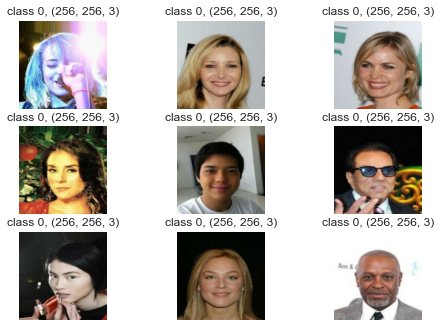

In [7]:
for images, labels in dataset.take(1):
    for img in range(9):
        ax = plt.subplot(3, 3, img + 1)
        plt.imshow(images[img].numpy().astype('uint8'))
        plt.title(f'class {int(labels[img])}, {images[img].shape}')
        plt.axis("off")

Images in dataset conform to only one class (celebrity) and are of shape (256, 256, 3).

#### Attributes table

In [39]:
df_celeb_attributes = pd.read_csv('./kaggle_celeb_images/list_attr_celeba.csv')

In [51]:
df_celeb_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   image_id             202599 non-null  object
 1   5_o_Clock_Shadow     202599 non-null  int64 
 2   Arched_Eyebrows      202599 non-null  int64 
 3   Attractive           202599 non-null  int64 
 4   Bags_Under_Eyes      202599 non-null  int64 
 5   Bald                 202599 non-null  int64 
 6   Bangs                202599 non-null  int64 
 7   Big_Lips             202599 non-null  int64 
 8   Big_Nose             202599 non-null  int64 
 9   Black_Hair           202599 non-null  int64 
 10  Blond_Hair           202599 non-null  int64 
 11  Blurry               202599 non-null  int64 
 12  Brown_Hair           202599 non-null  int64 
 13  Bushy_Eyebrows       202599 non-null  int64 
 14  Chubby               202599 non-null  int64 
 15  Double_Chin          202599 non-nu

In [42]:
df_celeb_attributes.head(3).T

,0,1,2
image_id,000001.jpg,000002.jpg,000003.jpg
5_o_Clock_Shadow,-1,-1,-1
Arched_Eyebrows,1,-1,-1
Attractive,1,-1,-1
Bags_Under_Eyes,-1,1,-1
Bald,-1,-1,-1
Bangs,-1,-1,-1
Big_Lips,-1,-1,1
Big_Nose,-1,1,-1
Black_Hair,-1,-1,-1


In [52]:
df_celeb_attributes.describe()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
count,202599.000000,202599.000000,202599.00000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,...,202599.000000,202599.000000,202599.000000,202599.000000,202599.00000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000
mean,-0.777728,-0.466039,0.02501,-0.590857,-0.955113,-0.696849,-0.518408,-0.530935,-0.521498,-0.704016,...,-0.886979,-0.035839,-0.583196,-0.360866,-0.62215,-0.903079,-0.055129,-0.754066,-0.854570,0.547234
std,0.628602,0.884766,0.99969,0.806778,0.296241,0.717219,0.855135,0.847414,0.853255,0.710186,...,0.461811,0.999360,0.812333,0.932620,0.78290,0.429475,0.998482,0.656800,0.519338,0.836982
min,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
50%,-1.000000,-1.000000,1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
75%,-1.000000,1.000000,1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,1.000000,-1.000000,1.000000,-1.00000,-1.000000,1.000000,-1.000000,-1.000000,1.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


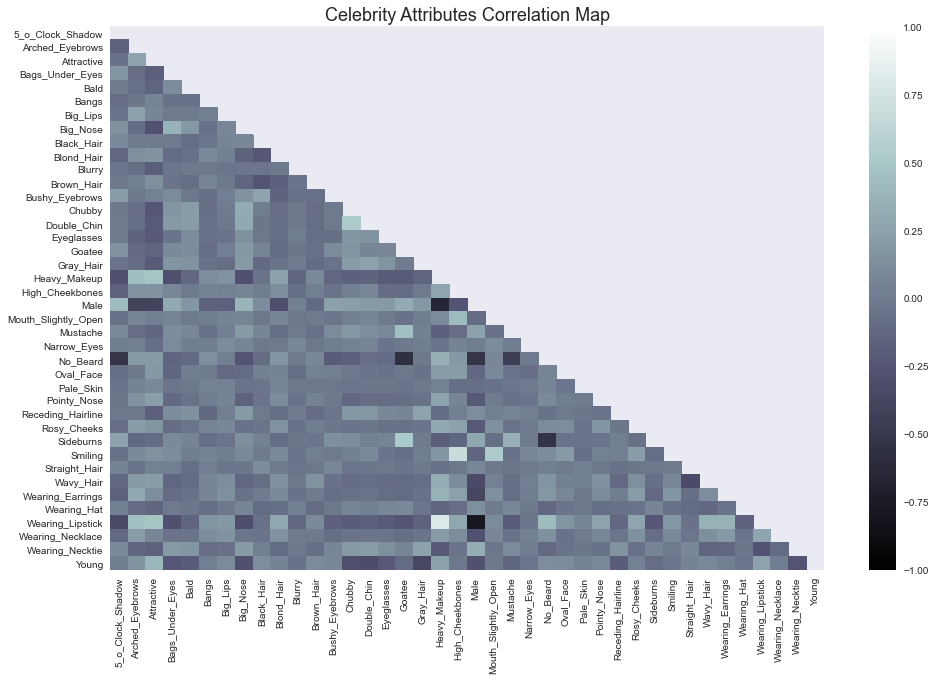

In [380]:
plt.figure(figsize=(16,10))
attr_corrs = df_celeb_attributes.drop(columns='image_id').corr()
sns.heatmap(attr_corrs,
            cmap='bone', vmax=1, vmin=-1,
            mask=np.triu(np.ones_like(attr_corrs, dtype=bool)));
plt.title('Celebrity Attributes Correlation Map', fontsize=18)
plt.savefig('./graphics/attribute_corr.png')

#### Bounding boxes table
As will be seen from below, the bounding boxes table for CelebA dataset likely were with reference to their original image frames, using a centroid point with width and height data.

In [35]:
# read in data
df_celeb_bbox = pd.read_csv('./kaggle_celeb_images/list_bbox_celeba.csv')

In [36]:
# check for nulls
df_celeb_bbox.isnull().sum()

image_id    0
x_1         0
y_1         0
width       0
height      0
dtype: int64

In [37]:
# view data
df_celeb_bbox.head(3)

,image_id,x_1,y_1,width,height
0,000001.jpg,95,71,226,313
1,000002.jpg,72,94,221,306
2,000003.jpg,216,59,91,126


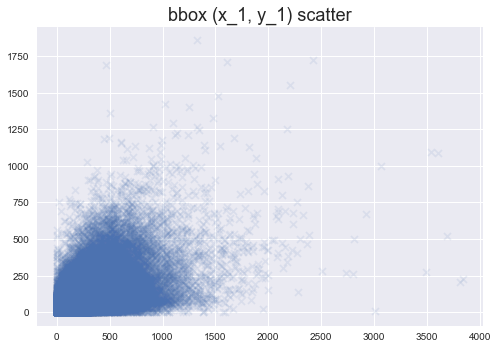

In [385]:
# plot scatter for (x_1, y_1)
plt.scatter(df_celeb_bbox['x_1'], df_celeb_bbox['y_1'], 
            marker='x', alpha=0.1);
plt.title('bbox (x_1, y_1) scatter', fontsize=18)
plt.savefig('./graphics/bbox_xy_scatter.png')

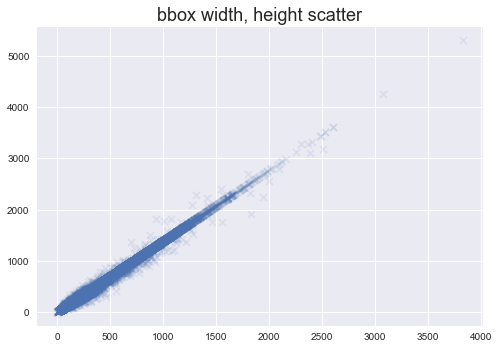

In [386]:
# plot scatter for width and height
plt.scatter(df_celeb_bbox['width'], df_celeb_bbox['height'], 
            marker='x', alpha=0.1);
plt.title('bbox width, height scatter', fontsize=18)
plt.savefig('./graphics/bbox_widthheight_scatter.png')

#### Eval Partition table

In [388]:
df_celeb_eval_partition = pd.read_csv('./kaggle_celeb_images/list_eval_partition.csv')

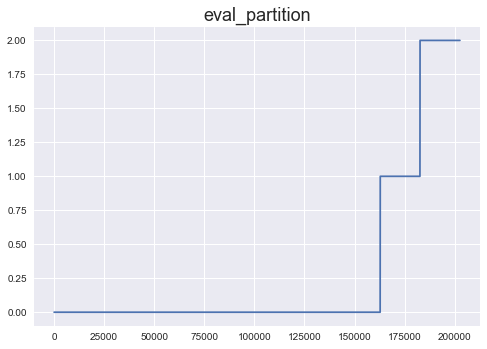

In [389]:
plt.plot(df_celeb_eval_partition['partition']);
plt.title('eval_partition', fontsize=18)
plt.savefig('./graphics/eval_partition.png')

In [4]:
df_celeb_landmarks = pd.read_csv('./kaggle_celeb_images/list_landmarks_align_celeba.csv')

In [20]:
df_celeb_landmarks.head(3)

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158


In [34]:
df_celeb_landmarks.isnull().sum()

image_id        0
lefteye_x       0
lefteye_y       0
righteye_x      0
righteye_y      0
nose_x          0
nose_y          0
leftmouth_x     0
leftmouth_y     0
rightmouth_x    0
rightmouth_y    0
dtype: int64

In [5]:
# check if landmarks are bounded within (256, 256) frame
df_celeb_landmarks.describe() < 256

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
count,False,False,False,False,False,False,False,False,False,False
mean,True,True,True,True,True,True,True,True,True,True
std,True,True,True,True,True,True,True,True,True,True
min,True,True,True,True,True,True,True,True,True,True
25%,True,True,True,True,True,True,True,True,True,True
50%,True,True,True,True,True,True,True,True,True,True
75%,True,True,True,True,True,True,True,True,True,True
max,True,True,True,True,True,True,True,True,True,True


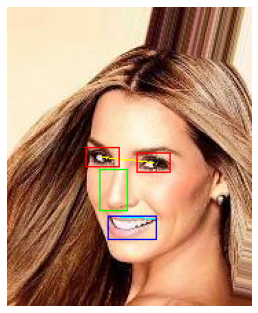

In [373]:
# read in first image
drawing = convert_rgb(cv2.imread('./kaggle_celeb_images/img_align_celeba/img_align_celeba/000001.jpg'))
# draw in landmarks
# eyes
cv2.line(drawing,
         pt1=(df_celeb_landmarks['lefteye_x'][0],
              df_celeb_landmarks['lefteye_y'][0]),
         pt2=(df_celeb_landmarks['righteye_x'][0],
              df_celeb_landmarks['righteye_y'][0]),
         color=(255, 255, 0), thickness=1)
eye_width = 25
eye_height = 15
cv2.rectangle(drawing,
              pt1=(df_celeb_landmarks['lefteye_x'][0] - int(eye_width/2),
                   df_celeb_landmarks['lefteye_y'][0] - int(eye_height/2)),
              pt2=(df_celeb_landmarks['lefteye_x'][0] + int(eye_width/2),
                   df_celeb_landmarks['lefteye_y'][0] + int(eye_height/2)),
              color=(255, 0, 0), thickness=1)
cv2.rectangle(drawing,
              pt1=(df_celeb_landmarks['righteye_x'][0] - int(eye_width/2),
                   df_celeb_landmarks['righteye_y'][0] - int(eye_height/2)),
              pt2=(df_celeb_landmarks['righteye_x'][0] + int(eye_width/2),
                   df_celeb_landmarks['righteye_y'][0] + int(eye_height/2)),
              color=(255, 0, 0), thickness=1)
# mouth
cv2.line(drawing,
         pt1=(df_celeb_landmarks['leftmouth_x'][0],
              df_celeb_landmarks['leftmouth_y'][0]),
         pt2=(df_celeb_landmarks['rightmouth_x'][0],
              df_celeb_landmarks['rightmouth_y'][0]),
         color=(0, 255, 255), thickness=1)
mouth_height = 15
cv2.rectangle(drawing,
              pt1=(df_celeb_landmarks['leftmouth_x'][0],
                   df_celeb_landmarks['leftmouth_y'][0]),
              pt2=(df_celeb_landmarks['rightmouth_x'][0],
                   df_celeb_landmarks['rightmouth_y'][0] + mouth_height),
              color=(0, 0, 255), thickness=1)
# only one (x, y) coordinate for nose
nose_width = 20
nose_height = 30
cv2.rectangle(drawing,
              pt1=(df_celeb_landmarks['nose_x'][0] - int(nose_width/2),
                   df_celeb_landmarks['nose_y'][0] - int(nose_height * 0.8)),
              pt2=(df_celeb_landmarks['nose_x'][0] + int(nose_width/2),
                   df_celeb_landmarks['nose_y'][0] + int(nose_height * 0.2)),
              color=(0, 255, 0), thickness=1)
plt.axis('off')
plt.imshow(drawing);
plt.savefig('./graphics/face_with_boxes.png')

Landmarks data for each frontal face image indicate:
- the centroids for left & right eye (yellow line; boxed in red),
- the tip of the nose (boxed in green), and
- the left and right corners of the mouth (cyan line; boxed in blue).

### Building facial landmarks dataset
To keep things simple, we will pull only eye features, cropping them into a *32 x 32* frame.

#### Train set: Left eyes (1000 images)

In [125]:
for i in range(1,1001):
    img = cv2.imread(f'./kaggle_celeb_images/img_align_celeba/img_align_celeba/{str(i).zfill(6)}.jpg')
    eye_width = 32
    eye_height = 32
    x = df_celeb_landmarks['lefteye_x'][i - 1] - int(eye_width/2)
    y = df_celeb_landmarks['lefteye_y'][i - 1] - int(eye_height/2)
    crop_img = img[y : y + eye_height,
                   x : x + eye_width]
    cv2.imwrite(f'./data/lefteye/lefteye_{str(i).zfill(6)}.jpg', crop_img)

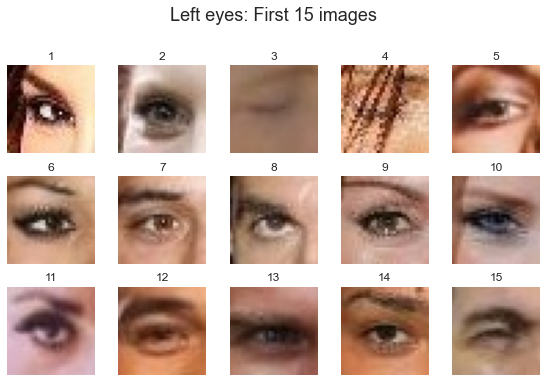

In [183]:
display_count = 15
ncols_display = 5

for i in range(1, display_count + 1):
    ax = plt.subplot(int(np.ceil(display_count / ncols_display)), ncols_display, i)
    ax.imshow(convert_rgb(cv2.imread(f'./data/lefteye/lefteye_{str(i).zfill(6)}.jpg')))
    ax.set_title(f'{i}')
    ax.axis('off')
plt.suptitle(f'Left eyes: First {display_count} images', fontsize=18);
plt.tight_layout(pad=2)
# plt.savefig('./graphics/left_eyes_15.png')

![left_eyes](./graphics/left_eyes_15.png)

#### Train set: Right eyes (1000 images)

In [127]:
for i in range(1,1001):
    img = cv2.imread(f'./kaggle_celeb_images/img_align_celeba/img_align_celeba/{str(i).zfill(6)}.jpg')
    eye_width = 32
    eye_height = 32
    x = df_celeb_landmarks['righteye_x'][i - 1] - int(eye_width/2)
    y = df_celeb_landmarks['righteye_y'][i - 1] - int(eye_height/2)
    crop_img = img[y : y + eye_height,
                   x : x + eye_width]
    cv2.imwrite(f'./data/righteye/righteye_{str(i).zfill(6)}.jpg', crop_img)

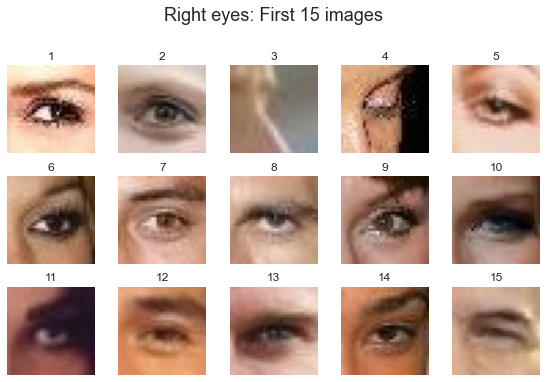

In [182]:
display_count = 15
ncols_display = 5

for i in range(1, display_count + 1):
    ax = plt.subplot(int(np.ceil(display_count / ncols_display)), ncols_display, i)
    ax.imshow(convert_rgb(cv2.imread(f'./data/righteye/righteye_{str(i).zfill(6)}.jpg')))
    ax.set_title(f'{i}')
    ax.axis('off')
plt.suptitle(f'Right eyes: First {display_count} images', fontsize=18);
plt.tight_layout(pad=2)
# plt.savefig('./graphics/right_eyes_15.png')

![right eyes](./graphics/right_eyes_15.png)

### Building test set

In [306]:
for i in range(1001,1101):
    img = cv2.imread(f'./kaggle_celeb_images/img_align_celeba/img_align_celeba/{str(i).zfill(6)}.jpg')
    eye_width = 32
    eye_height = 32
    x = df_celeb_landmarks['lefteye_x'][i - 1] - int(eye_width/2)
    y = df_celeb_landmarks['lefteye_y'][i - 1] - int(eye_height/2)
    crop_img = img[y : y + eye_height,
                   x : x + eye_width]
    cv2.imwrite(f'./test/lefteye_{str(i).zfill(6)}.jpg', crop_img)
    
for i in range(1001,1101):
    img = cv2.imread(f'./kaggle_celeb_images/img_align_celeba/img_align_celeba/{str(i).zfill(6)}.jpg')
    eye_width = 32
    eye_height = 32
    x = df_celeb_landmarks['righteye_x'][i - 1] - int(eye_width/2)
    y = df_celeb_landmarks['righteye_y'][i - 1] - int(eye_height/2)
    crop_img = img[y : y + eye_height,
                   x : x + eye_width]
    cv2.imwrite(f'./test/righteye_{str(i).zfill(6)}.jpg', crop_img)

### Model 1
#### Viola-Jones object detection framework
The Viola-Jones framework&mdash;well known for frontal face detection&mdash;is used in face detection features of apps like Snapchat (see [article](https://www.forbes.com/sites/quora/2017/03/17/the-inner-workings-of-snapchats-faceswap-technology/?sh=6e7fcd9264c7)).

[Back to top](#Outcomes)

**Summary**:

1. Images are computationally expensive to process; the framework contributes a new way of representing the image: as an *integral image* (also related: summed-area-tables).
>- Computing Haar-like features, which are used for detection, can hence be done in constant time, i.e. $O(1)$ *(check out Big O notation)*. This means that time taken to compute does not depend on input size.
1. The framework also leverages the AdaBoost process in feature selection for "fast classification".
>- This is important because *Haar-like features* per image are greater than number of pixels in the image.
>- In the framework, features, rather than pixels, are used directly. Simple rectangle features are used.
1. The paper also describes how to focus attention on "promising regions of the image". This also has wide-reaching implications for  practical use.
>- Using a trained classifier, the number of locations to pay attention to for more complex detection is reduced by more than half. 
>- Sub-windows that do not "pass" are not processed further.

**Reference / Paper**: Viola, P. & Jones, M. (2001). "Robust Real-time Object Detection". Second International Workshop on Statistical and Computational Theories of Vision -- Modeling, Learning, Computing, and Sampling. Vancouver, Canada, July 13, 2001. [LINK](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-IJCV-01.pdf)

**Useful summary article**: [LINK](https://towardsdatascience.com/viola-jones-algorithm-and-haar-cascade-classifier-ee3bfb19f7d8)

#### Integral images:
- Value at point (x, y) = Sum (pixels above and to left of point)

*Useful readings*
- https://theailearner.com/tag/cv2-integral/
- https://levelup.gitconnected.com/the-integral-image-4df3df5dce35

===== Test Image, <class 'numpy.ndarray'> =====
[[233 233 233 ... 232 241 241]
 [233 233 233 ... 234 241 241]
 [233 233 233 ... 236 241 242]
 ...
 [ 88  63  93 ...  72  73  73]
 [ 77  85 113 ...  66  68  68]
 [115 151 192 ...  66  68  68]]
===== Shape =====
(218, 178)


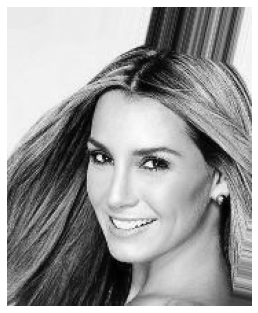

In [62]:
#  Loading the image to be tested
test_image = cv2.imread('./kaggle_celeb_images/img_align_celeba/img_align_celeba/000001.jpg')
# Converting to grayscale as opencv expects detector takes in input gray scale images
test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
print(f'===== Test Image, {type(test_image_gray)} =====')
print(test_image_gray)
print('===== Shape =====')
print(test_image_gray.shape)
# Displaying grayscale image
plt.axis(False)
plt.imshow(test_image_gray, cmap='gray');

In [85]:
# getting to an integral image using cv2
int_img_cv2 = cv2.integral(test_image_gray)
display(int_img_cv2.shape, int_img_cv2)

(219, 179)

array([[      0,       0,       0, ...,       0,       0,       0],
       [      0,     233,     466, ...,   31180,   31421,   31662],
       [      0,     466,     932, ...,   62286,   62768,   63250],
       ...,
       [      0,   38151,   75925, ..., 5598109, 5636022, 5674017],
       [      0,   38228,   76087, ..., 5614686, 5652667, 5690730],
       [      0,   38343,   76353, ..., 5631455, 5669504, 5707635]],
      dtype=int32)

The below is a class diagram by César de Souza in Csharp when building up the framework.

![Souza's Class Diagram](https://www.codeproject.com/KB/Articles/441226/class-diagram.png)


*Reference: https://www.codeproject.com/Articles/441226/Haar-feature-Object-Detection-in-Csharp*


While some time was invested in trying to build something similar from scratch using Python, it was decidedly something out of reach for now.

Below showcases how the Viola Jones object detection framework is executed using a downloaded cascade classifier (from the [OpenCV Github](https://github.com/opencv/opencv/tree/master/data)).

In [188]:
# Source: https://github.com/opencv/opencv/tree/master/data
haar_cascade_face = cv2.CascadeClassifier(
    './opencv_data/haarcascades/haarcascade_frontalface_alt2.xml'
)

In [186]:
def detect_faces(cascade, test_image, scaleFactor = 1.1):
    # create a copy of the image to prevent any changes to the original one.
    image_copy = test_image.copy()
    
    #convert the test image to gray scale as opencv face detector expects gray images
    gray_image = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
    
    # Applying the haar classifier to detect faces
    faces_rect = cascade.detectMultiScale(
        gray_image,
        scaleFactor=scaleFactor, 
        minNeighbors=5)
    
    detection_count = 0
    for (x, y, w, h) in faces_rect:
        cv2.rectangle(
            img=image_copy,
            pt1=(x, y),
            pt2=(x+w, y+h),
            color=(0, 255, 0),
            thickness=2)
        detection_count += 1
        
    print(f'{detection_count} faces detected')
    return image_copy

In [22]:
faces_rects = haar_cascade_face.detectMultiScale(
    test_image_gray,
    scaleFactor = 1.2,
    minNeighbors = 5);

# Let us print the no. of faces found
print('Faces found: ', len(faces_rects))

Faces found:  1


In [23]:
for (x,y,w,h) in faces_rects:
     cv2.rectangle(test_image, (x, y), (x+w, y+h), (0, 255, 0), 2)

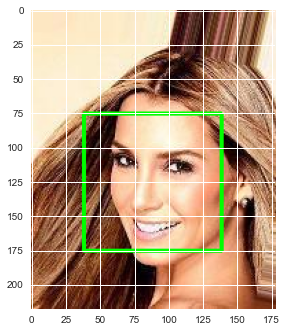

In [84]:
#convert image to RGB and show image
plt.imshow(convert_rgb(test_image));

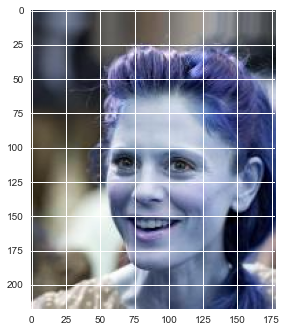

In [46]:
#loading image
test_image2 = cv2.imread(
    './kaggle_celeb_images/img_align_celeba/img_align_celeba/000002.jpg'
)
plt.imshow(test_image2);

In [39]:
#call the function to detect faces
faces = detect_faces(haar_cascade_face, test_image2)

1 faces detected


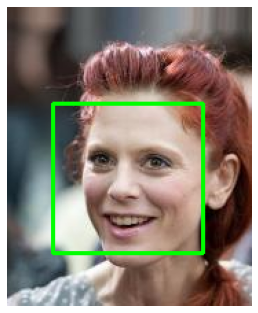

In [42]:
#convert to RGB and display image
plt.imshow(convert_rgb(faces))
plt.axis('off');

7 faces detected
Wall time: 226 ms


(-0.5, 1370.5, 908.5, -0.5)

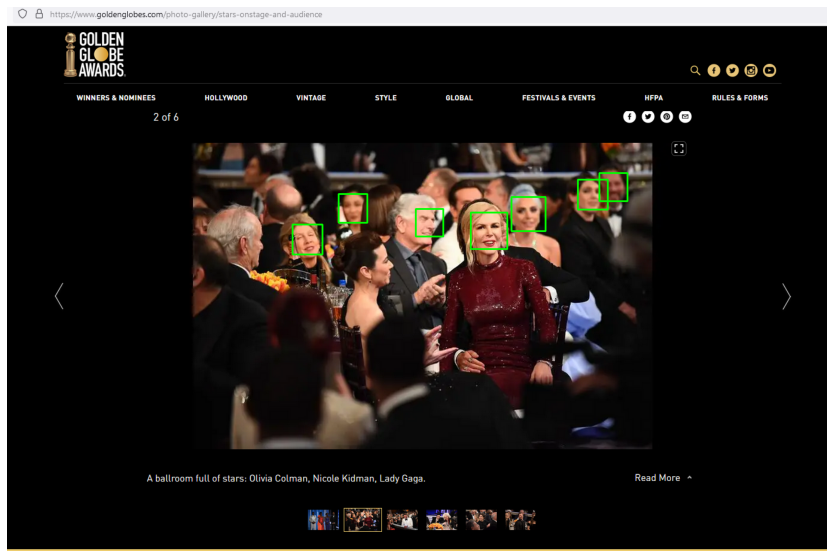

In [383]:
%%time
#loading image
test_image3 = cv2.imread(
    './graphics/golden_globes_1.png'
)

#call the function to detect faces
faces = detect_faces(haar_cascade_face, test_image3)

#convert to RGB and display image
plt.figure(figsize=(16,10))
plt.imshow(convert_rgb(faces))
plt.axis('off');

In [381]:
cv2.imwrite('./graphics/detected_faces.png', faces)

True

#### Performance of Viola-Jones frontal face detector
- Since we are looking for frontal faces only, **all frontal faces (7 of 7) were detected**, even those that were blurred in the background.
- The detector also **ignored the thumbnail** at the bottom of the image.
- Notably, this took **less than one second** (from the point of reading in the image to plotting out the detected frontal faces)!

#### Face-blurring function

In [202]:
# Credit: https://github.com/nithindd/aind_computer_vision/blob/master/CV_project.ipynb
def blurface(image):
    denoised_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 21, 7)

    gray = cv2.cvtColor(denoised_image, cv2.COLOR_RGB2GRAY)

    # Extract the pre-trained face detector from an xml file
    face_cascade = cv2.CascadeClassifier('./opencv_data/haarcascades/haarcascade_frontalface_default.xml')

    # Detect the faces in image
    faces = face_cascade.detectMultiScale(gray, 1.1, 10)

    # Make a copy of the orginal image to blur
    final_image = np.copy(image)

    # Blur
    width = 40
    kernel = np.ones((width, width),np.float32) / 1600
    image_with_blur = cv2.filter2D(image, -1, kernel)

    for (x,y,w,h) in faces:
        padding = 30
        x_start = max(x - padding, 0)
        y_start = max(y - padding, 0)
        x_end = min(x + w + padding, image.shape[1])
        y_end = min(y + h + padding, image.shape[0])
        final_image[y_start:y_end, x_start:x_end] = cv2.filter2D(image_with_blur[y_start:y_end, x_start:x_end], -1, kernel)
    
    return final_image

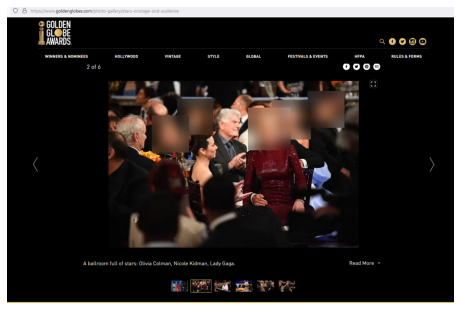

In [374]:
plt.imshow(convert_rgb(blurface(test_image3)))
plt.axis('off');
plt.savefig('./graphics/blurred_faces.png')

#### Model 2
Sequential CNN model with custom dropout layer

[Back to top](#Outcomes)

*Load in data*

In [338]:
data_dir = './data/'

img_height = 32
img_width = 32
batch_size = 20

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

train_ds_class_names = train_ds.class_names
print('train_ds Classes: ', train_ds_class_names)

val_ds_class_names = val_ds.class_names
print('val_ds Classes: ', val_ds_class_names)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 2000 files belonging to 2 classes.
Using 400 files for validation.
train_ds Classes:  ['lefteye', 'righteye']
val_ds Classes:  ['lefteye', 'righteye']


You can create your own layers with specific characteristics by setting up a new class for that layer object, inheriting from a superclass via `super()`.

In [206]:
# create monte-carlo dropout class (MCDropout)
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [302]:
# instantiate model with layers
model_cnn_mcdropout = keras.models.Sequential(
    [
        keras.layers.Conv2D(filters=8,
                            kernel_size=3,
                            activation='relu',
                            input_shape=(32, 32, 3)),
        keras.layers.Conv2D(filters=16,
                            kernel_size=3,
                            activation='relu'),
        keras.layers.Flatten(input_shape=[]),
        MCDropout(rate=0.2),
        keras.layers.Dense(256,
                           activation='relu',
                           kernel_initializer='he_normal'),
        MCDropout(rate=0.2),
        keras.layers.Dense(256,
                           activation='relu',
                           kernel_initializer='he_normal'),
        MCDropout(rate=0.2),
        keras.layers.Dense(2,
                           activation='softmax'),
    ]
)

In [311]:
# compile
model_cnn_mcdropout.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['acc'],
)

**Cross Entropy** helps determine how well model fits data.

It is represented by:<br>
<center><br>
$-\sum_{class=1}^{M} Observed_{class} * log(PredictedProbability_{class})$
</center><br>
where *M* is the total number of classes.

In neural networks, the last layer, which is usually a `softmax` layer, converts the output values into predicted probabilities for each possible class.

In [312]:
# fit
epochs = 50

history = model_cnn_mcdropout.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    verbose=1
)

Epoch 1/50
80/80 [==============================] - 2s 24ms/step - loss: 46.2160 - acc: 0.6731 - val_loss: 0.5572 - val_acc: 0.7700
Epoch 2/50
80/80 [==============================] - 2s 23ms/step - loss: 0.4403 - acc: 0.8306 - val_loss: 0.5549 - val_acc: 0.8100
Epoch 3/50
80/80 [==============================] - 2s 22ms/step - loss: 0.2539 - acc: 0.9006 - val_loss: 0.4217 - val_acc: 0.8475
Epoch 4/50
80/80 [==============================] - 2s 23ms/step - loss: 0.1708 - acc: 0.9406 - val_loss: 0.6512 - val_acc: 0.8375
Epoch 5/50
80/80 [==============================] - 2s 23ms/step - loss: 0.1228 - acc: 0.9525 - val_loss: 0.4589 - val_acc: 0.8500
Epoch 6/50
80/80 [==============================] - 2s 23ms/step - loss: 0.1682 - acc: 0.9575 - val_loss: 0.5916 - val_acc: 0.8850
Epoch 7/50
80/80 [==============================] - 2s 23ms/step - loss: 0.1148 - acc: 0.9594 - val_loss: 0.6461 - val_acc: 0.8525
Epoch 8/50
80/80 [==============================] - 2s 23ms/step - loss: 0.0617 - 

In [313]:
# save model
model_cnn_mcdropout.save('./models/cnn_mcdropout')

INFO:tensorflow:Assets written to: ./models/cnn_mcdropout\assets


In [354]:
history.history

{'loss': [46.21599578857422,
  0.44028255343437195,
  0.2539287805557251,
  0.17083945870399475,
  0.12275640666484833,
  0.16815832257270813,
  0.11478015780448914,
  0.06168457493185997,
  0.07685279101133347,
  0.09392271935939789,
  0.051426175981760025,
  0.0802297592163086,
  0.07076594978570938,
  0.09917082637548447,
  0.05527679622173309,
  0.04348154366016388,
  0.047162022441625595,
  0.09851941466331482,
  0.06413953751325607,
  0.061560437083244324,
  0.06191926449537277,
  0.043572064489126205,
  0.1126779168844223,
  0.036619022488594055,
  0.029446406289935112,
  0.03343510627746582,
  0.18528126180171967,
  0.12581327557563782,
  0.04234622046351433,
  0.029903912916779518,
  0.020166851580142975,
  0.10487589985132217,
  0.0887887254357338,
  0.023325471207499504,
  0.04674220085144043,
  0.011562304571270943,
  0.009012686088681221,
  0.014490783214569092,
  0.0068040634505450726,
  0.008520470932126045,
  0.021453984081745148,
  0.013870138674974442,
  0.01067131664

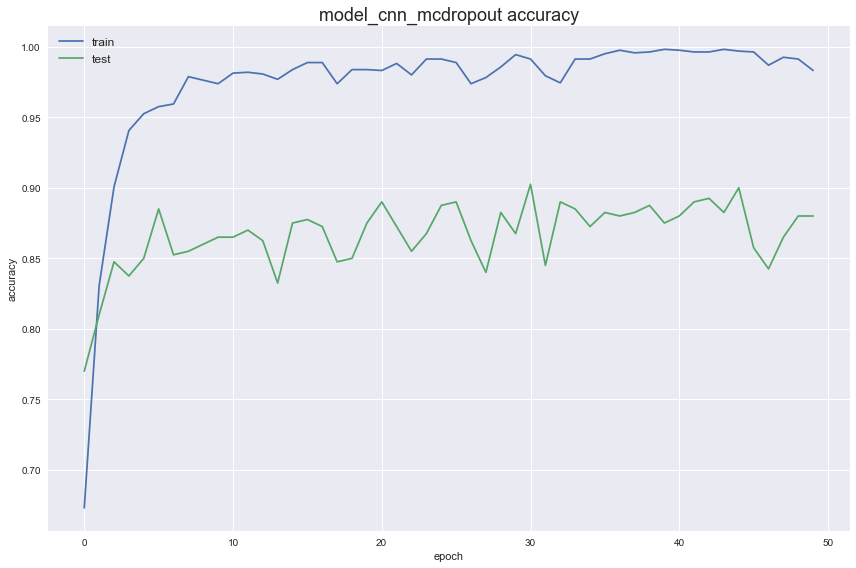

In [400]:
# summarize history for accuracy
plt.figure(figsize=(12,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model_cnn_mcdropout accuracy', fontsize=18)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left', fontsize=12)
plt.tight_layout()
plt.savefig('./graphics/model_cnn_acc.png')

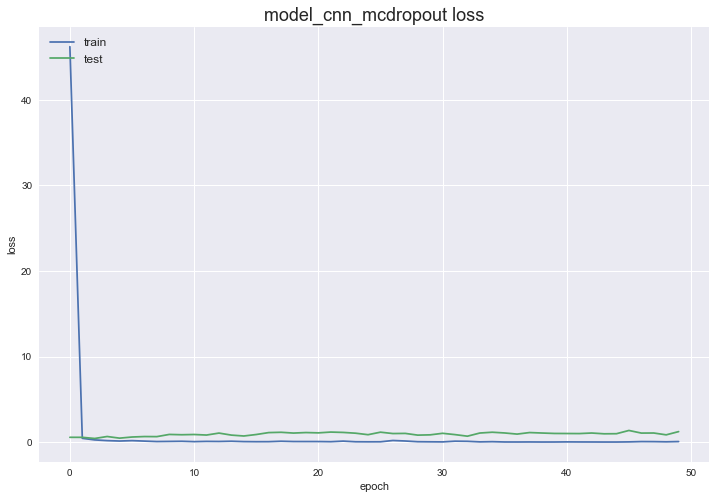

In [399]:
# summarize history for loss
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_cnn_mcdropout loss', fontsize=18)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left', fontsize=12)
plt.savefig('./graphics/model_cnn_loss.png')

In [372]:
model_cnn_mcdropout.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 30, 30, 8)         224       
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 16)        1168      
                                                                 
 flatten_3 (Flatten)         (None, 12544)             0         
                                                                 
 mc_dropout_9 (MCDropout)    (None, 12544)             0         
                                                                 
 dense_9 (Dense)             (None, 256)               3211520   
                                                                 
 mc_dropout_10 (MCDropout)   (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 256)              

#### Model 3

[Back to top](#Outcomes)

Pre-trained VGG16 model

shower_curtain (17.15%)


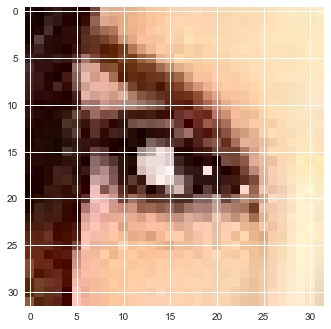

In [327]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
# load the model
model_vgg16 = VGG16()
# load an image from file
plt.imshow(convert_rgb(cv2.imread('./data/lefteye/lefteye_000001.jpg')))
# load in version with target size set to suit VGG16
image = load_img('./data/lefteye/lefteye_000001.jpg',
                 target_size=(224, 224))
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
# predict the probability across all output classes
yhat = model_vgg16.predict(image)
# convert the probabilities to class labels
label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))

The "left" eye (or any eye) is not recognized by the pretrained model.

This is only to be expected since VGG16 was not trained to recognize facial features.

The way to resolve this is to perform transfer learning, where the VGG16 model is trained to take in additional classes.

In [329]:
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### Transfer Learning with VGG16
In execution of the custom model, we effectively add the pretrained base model layers at the start of the custom model (`tf.keras.models.Sequential()`).

What we are trying to achieve is get a well-trained model to perform feature extraction. However, we do not really care about the classes VGG16 was originally trained on (over 1000 classes from well over 10 million images).

Hence, we set:
- `include_top = False` and
-`model.trainable = False`.

In [348]:
pretrained_base = VGG16(
    weights='imagenet', include_top=False, input_shape=(32,32,3)
)
pretrained_base.trainable = False

In [350]:
model_vgg16_custom = keras.models.Sequential(
    [
        pretrained_base,
        # add global average pooling layer to "soften" computational intensity for model
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation=tf.nn.relu, name="dense1"),
        keras.layers.Dense(10, activation=tf.nn.relu, name="dense2"),
        keras.layers.Dense(2, activation=tf.nn.softmax)
    ]
)

In [359]:
# compile
model_vgg16_custom.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

In [367]:
%%time
# fit
epochs = 50
history_vgg16 = model_vgg16_custom.fit(train_ds,
                                       validation_data=val_ds,
                                       epochs=epochs,
                                       verbose=1)

Epoch 1/50
80/80 [==============================] - 6s 74ms/step - loss: 0.0393 - acc: 0.9881 - val_loss: 1.5119 - val_acc: 0.7300
Epoch 2/50
80/80 [==============================] - 6s 73ms/step - loss: 0.0215 - acc: 0.9956 - val_loss: 1.5581 - val_acc: 0.7325
Epoch 3/50
80/80 [==============================] - 6s 73ms/step - loss: 0.0060 - acc: 0.9987 - val_loss: 1.5868 - val_acc: 0.7350
Epoch 4/50
80/80 [==============================] - 6s 73ms/step - loss: 0.0027 - acc: 1.0000 - val_loss: 1.7185 - val_acc: 0.7475
Epoch 5/50
80/80 [==============================] - 6s 72ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 1.7384 - val_acc: 0.7450
Epoch 6/50
80/80 [==============================] - 6s 72ms/step - loss: 9.2870e-04 - acc: 1.0000 - val_loss: 1.7618 - val_acc: 0.7425
Epoch 7/50
80/80 [==============================] - 6s 72ms/step - loss: 8.5132e-04 - acc: 1.0000 - val_loss: 1.7844 - val_acc: 0.7450
Epoch 8/50
80/80 [==============================] - 6s 73ms/step - loss: 7.

In [368]:
model_vgg16_custom.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten_9 (Flatten)         (None, 512)               0         
                                                                 
 dense1 (Dense)              (None, 256)               131328    
                                                                 
 dense2 (Dense)              (None, 10)                2570      
                                                                 
 dense_16 (Dense)            (None, 2)                 22        
                                                      

In [369]:
model_vgg16_custom.save('./models/vgg_16_custom')

INFO:tensorflow:Assets written to: ./models/vgg_16_custom\assets


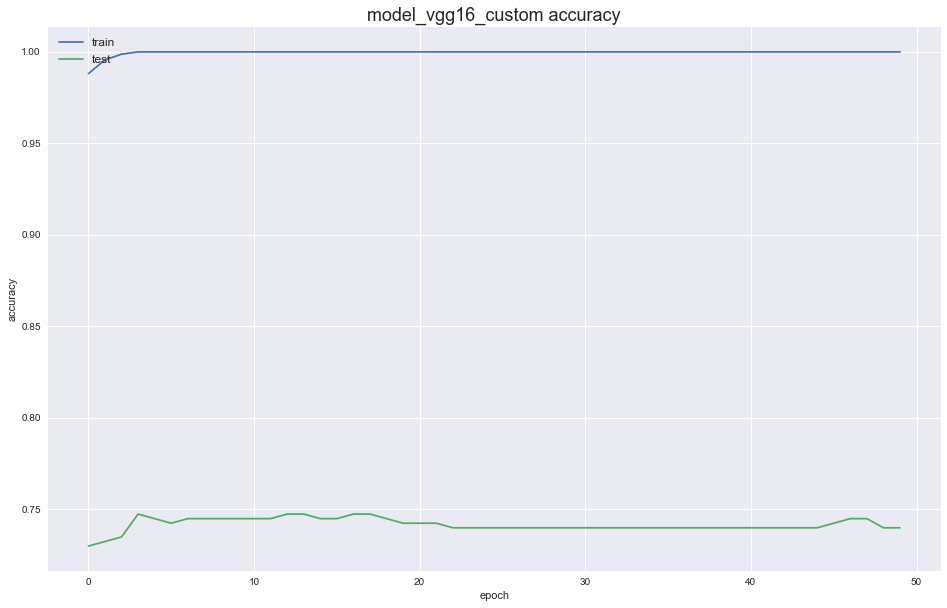

In [401]:
# summarize history for accuracy
plt.figure(figsize=(16,10))
plt.plot(history_vgg16.history['acc'])
plt.plot(history_vgg16.history['val_acc'])
plt.title('model_vgg16_custom accuracy', fontsize=18)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left', fontsize=12)
plt.savefig('./graphics/vgg_16_custom_acc.png')

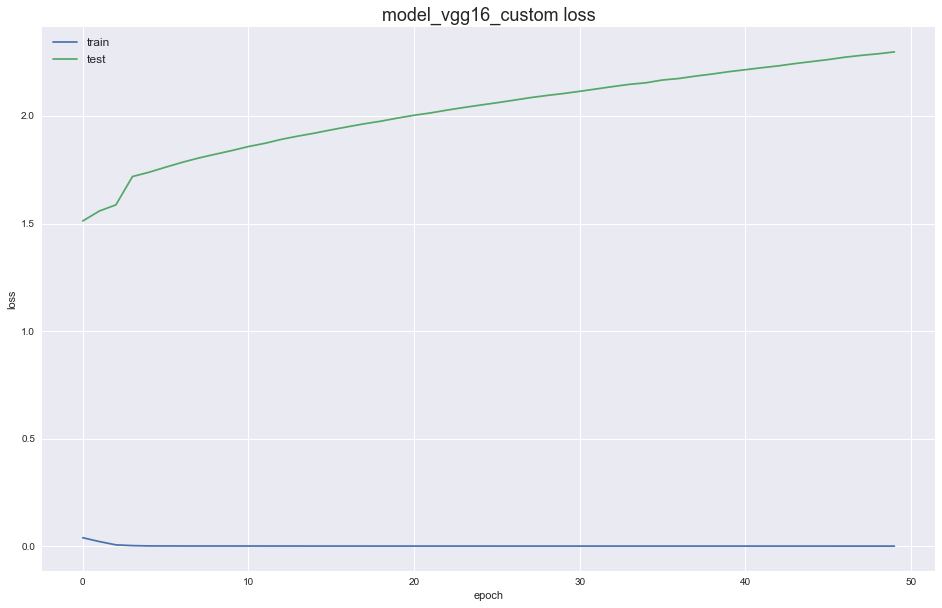

In [403]:
# summarize history for loss
plt.figure(figsize=(16,10))
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title('model_vgg16_custom loss', fontsize=18)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left', fontsize=12)
plt.savefig('./graphics/vgg_16_custom_loss.png')

We see diverging loss plots, indicative of some issues in the modelling.

## Future Development
We are able to stitch together many possibilities for experimentation based on the Kaggle dataset.

Next time, we may wish to build a classifier for whether a person is smiling or not based on their eye features.

Data in the attributes table includes whether the person in the image is smiling (`1`) or not (`-1`).

In [161]:
# Create smile dataframe
df_smile = df_celeb_attributes[['image_id', 'Smiling']].truncate(after=999)

# Lower-case columns
df_smile.columns = map(str.lower, df_smile.columns)

# Check df & truncation
df_smile.tail(3)

,image_id,smiling
997,000998.jpg,-1
998,000999.jpg,-1
999,001000.jpg,1


*Show images with smiling classes (1 for smiling, -1 for not smiling)*

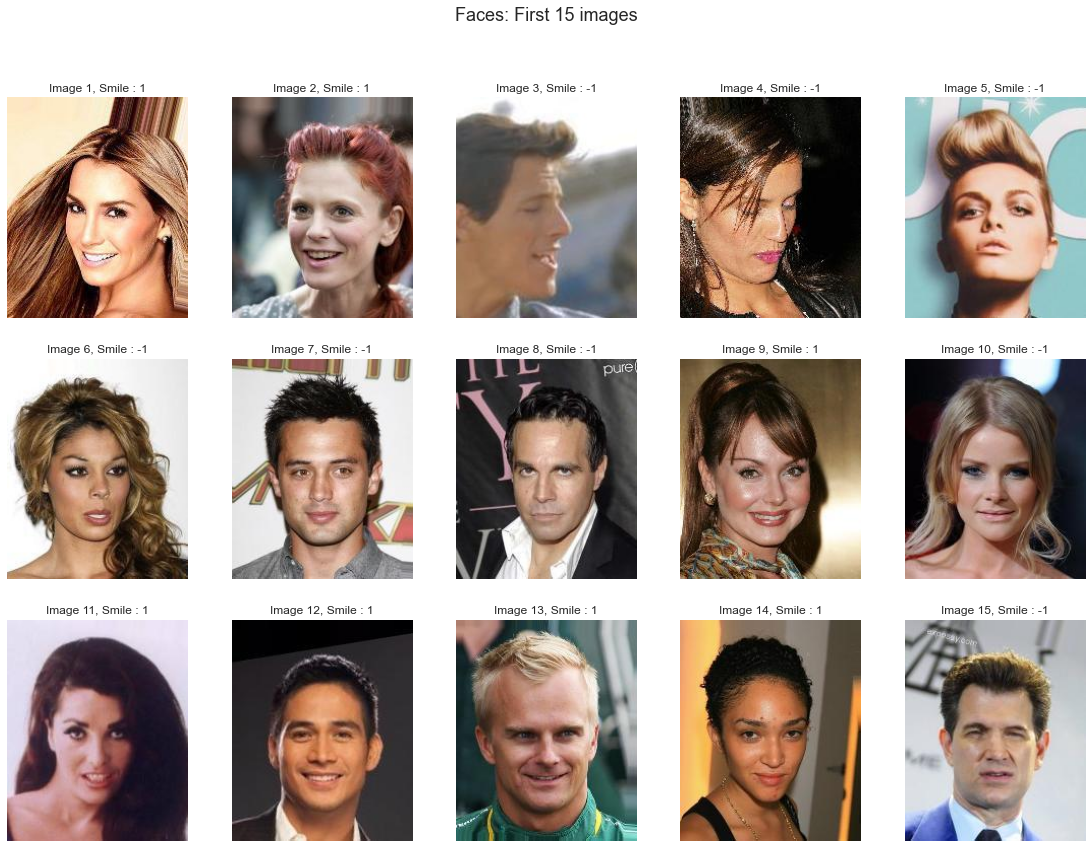

In [181]:
display_count = 15
ncols_display = 5

plt.figure(figsize=(16,12))

for i in range(1, display_count + 1):
    smile_class = df_smile['smiling'].loc[i - 1]
    ax = plt.subplot(int(np.ceil(display_count / ncols_display)), ncols_display, i)
    ax.imshow(convert_rgb(cv2.imread(f'./kaggle_celeb_images/img_align_celeba/img_align_celeba/{str(i).zfill(6)}.jpg')))
    ax.set_title(f'Image {i}, Smile : {smile_class}')
    ax.axis('off')
plt.suptitle(f'Faces: First {display_count} images', y=1, fontsize=18);
plt.tight_layout(pad=3)
# plt.savefig('./graphics/face_15.png')

![faces](./graphics/face_15.png)

### Bibliography

[Back to top](#Outcomes)

- Carl Doersch, Saurabh Singh, Abhinav Gupta, Josef Sivic, and Alexei A. Efros. What Makes Paris Look like Paris? ACM Transactions on Graphics (SIGGRAPH 2012), August 2012, vol. 31, No. 3. 
- S. Yang, P. Luo, C. C. Loy, and X. Tang, "From Facial Parts Responses to Face Detection: A Deep Learning Approach", in IEEE International Conference on Computer Vision (ICCV), 2015
- Viola, P. & Jones, M. (2001). "Robust Real-time Object Detection". Second International Workshop on Statistical and Computational Theories of Vision -- Modeling, Learning, Computing, and Sampling. Vancouver, Canada, July 13, 2001.

**Other links**:
- On CNN: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
```python
tf.keras.layers.Conv2D(
    filters, kernel_size, strides=(1, 1), padding='valid',
    data_format=None, dilation_rate=(1, 1), groups=1, activation=None,
    use_bias=True, kernel_initializer='glorot_uniform',
    bias_initializer='zeros', kernel_regularizer=None,
    bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
    bias_constraint=None, **kwargs
)
```
- On why use dropout between layers: https://arxiv.org/abs/1506.02142
- https://www.tensorflow.org/tutorials/load_data/images
- https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
- https://www.analyticsvidhya.com/blog/2020/11/tutorial-how-to-visualize-feature-maps-directly-from-cnn-layers/
- https://stackoverflow.com/questions/49295311/what-is-the-difference-between-flatten-and-globalaveragepooling2d-in-keras

#### Other cool things to check out
- https://github.com/tensorflow/tensor2tensor
- https://pyimagesearch.com/2020/06/22/turning-any-cnn-image-classifier-into-an-object-detector-with-keras-tensorflow-and-opencv/
- https://towardsdatascience.com/celebrity-face-generation-with-deep-convolutional-gans-40b96147a1c9
- to build helper functions
- how to extract feature maps for each model

---
### Acknowledgements

A shout out to thank my instructional team at [General Assembly](https://generalassemb.ly/), as well as the team at large for facilitating my learning journey. It's been fun learning with my coursemates and the GA community globally; thanks for the good times! Also, [Josh Starmer at StatQuest](https://www.youtube.com/watch?v=6ArSys5qHAU) has been a boon to society. :)

Thanks also to [IMDA](https://www.imda.gov.sg/) for their steadfast commitment to lifelong learning of digital skills and sponsorship of programmes like the [Tech Immersion and Placement Programme (TIPP)](https://www.imda.gov.sg/imtalent/programmes/tipp).

Special thanks to old buddies and new friends I've made in the process of reaching out via professional networks / through social circles. If you're reading this, you know who you are! :)

:bowtie: :beer: :pizza: :sparkling_heart: :muscle: :clap: :tada:

---